# Simple CNN architechture

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from Functions import import_raw_colour_image, import_raw_depth_image, show_depth_image, show_img
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import torch.nn.functional as F
from torchsummary import summary

plt.ion()   # interactive mode

## Reading in the csv data structure

In [3]:
import csv
with open('..\data_descriptions.csv', newline='') as csvfile: ###### data_descriptions csv must be in this relative location
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    count = 0
    for row in spamreader:
        if count == 0:
            folder_names = row
        else:
            num_files = row
        count = 1

In [4]:
for i in range(0,len(num_files)):
    num_files[i] = int(num_files[i])

In [5]:
list_of_numbers = ["{0:05}".format(i) for i in range(1, sum(num_files)+1)]
colour_filenames = []
depth_filenames = []
for num in list_of_numbers:
    colour_filenames.append(f"colour_{num}.raw")
    depth_filenames.append(f"depth_{num}.raw")

## Dataset class

In [41]:
class ModerateDataset(Dataset):

    def __init__(self, col_dir='', depth_dir='', transform=None, trans_on=False):
        self.path_names = {}
        for folder in folder_names:
            self.path_names[f"{folder}"] = {}
        for folder in folder_names:
            self.path_names[f'{folder}']['colour'] = {}
            self.path_names[f'{folder}']['depth'] = {}
        for i in range(1, num_files[0]):
            self.path_names['Sunny']['colour'][f"{i}"] = {}
            self.path_names['Sunny']['depth'][f"{i}"] = {}
        print("*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************")
        count = 0
        for folder in folder_names:
            for i in range(0, num_files[folder_names.index(folder)]):
                self.path_names[f'{folder}']['colour'][f'{i+1}'] = Path(f"C:/Users/Ben/OneDrive - Bournemouth University/Computer Vision/Moderate collection/{folder}/colour/{colour_filenames[count+i]}")  ## Change this path here!!!!
                self.path_names[f'{folder}']['depth'][f'{i+1}'] = Path(f"C:/Users/Ben/OneDrive - Bournemouth University/Computer Vision/Moderate collection/{folder}/depth/{depth_filenames[count+i]}")   ## Change this path here!!!!
            count = count + num_files[folder_names.index(folder)]
        
        self.transform = transform
        self.col_dir = col_dir
        self.depth_dir = depth_dir
        self.trans_on = trans_on

    def __getitem__(self,idx):
        if idx == 0:
            
            self.col_dir = self.path_names[f'{folder_names[0]}']['colour'][f'{idx+1}']
            self.depth_dir = self.path_names[f'{folder_names[0]}']['depth'][f'{idx+1}']
        
        if (idx>0 and idx <= num_files[0]):  ## 1-500

            self.col_dir = self.path_names[f'{folder_names[0]}']['colour'][f'{idx}']
            self.depth_dir = self.path_names[f'{folder_names[0]}']['depth'][f'{idx}']

        elif (idx > num_files[0] and idx < (sum(num_files[:2])+1)): ## 501 - 1500

            self.col_dir = self.path_names[f'{folder_names[1]}']['colour'][f'{idx-num_files[0]}']
            self.depth_dir = self.path_names[f'{folder_names[1]}']['depth'][f'{idx-num_files[0]}']

        elif (idx > sum(num_files[:2]) and idx < (sum(num_files[:3])+1) ): ## 1501 - 2600

            self.col_dir = self.path_names[f'{folder_names[2]}']['colour'][f'{idx-sum(num_files[:2])}'] # -1500
            self.depth_dir = self.path_names[f'{folder_names[2]}']['depth'][f'{idx-sum(num_files[:2])}']

        elif (idx > sum(num_files[:3]) and idx < (sum(num_files[:4])+1) ): ## 2601 - 5600

            self.col_dir = self.path_names[f'{folder_names[3]}']['colour'][f'{idx-sum(num_files[:3])}'] #-2600
            self.depth_dir = self.path_names[f'{folder_names[3]}']['depth'][f'{idx-sum(num_files[:3])}']
            
        elif (idx > sum(num_files[:4]) and idx < (sum(num_files[:5])+1) ): ## 5601 - 7857

            self.col_dir = self.path_names[f'{folder_names[4]}']['colour'][f'{idx-sum(num_files[:4])}'] # -5600
            self.depth_dir = self.path_names[f'{folder_names[4]}']['depth'][f'{idx-sum(num_files[:4])}']

        elif (idx > sum(num_files)):
            raise NameError('Index outside of range')

        col_img = import_raw_colour_image(self.col_dir)
        depth_img = import_raw_depth_image(self.depth_dir)
        if self.trans_on == True:
            col_img = torch.from_numpy(np.flip(col_img,axis=0).copy()) # apply any transforms
            depth_img = torch.from_numpy(np.flip(depth_img,axis=0).copy()) # apply any transforms
            col_img = col_img.transpose(0,2)
            col_img = col_img.transpose(1,2)
        if self.transform: # if any transforms were given to initialiser
            col_img = self.transform(col_img) # apply any transforms
        return col_img, depth_img
    
    def __len__(self):
        return sum(num_files)



In [42]:
total_Data = ModerateDataset(trans_on=True)  ## instancing the dataset

*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************


## Train/test splitting

Dataset is split 80/10/10 train/validation/testing

In [49]:
train_size = int(0.8 * len(total_Data))
val_size = int((len(total_Data) - train_size)/2)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(total_Data, [train_size, val_size, val_size])

In [50]:
batch_sz = 16
tr_dl  = DataLoader(train_dataset,  batch_size=batch_sz, shuffle=True,  num_workers=0)
val_dl = DataLoader(val_dataset,  batch_size=batch_sz, shuffle=True,  num_workers=0)
test_dl = DataLoader(test_dataset,  batch_size=batch_sz, shuffle=True,  num_workers=0)

## Training loop

In [10]:
def fit(net, tr_dl, val_dl, loss=nn.MSELoss(), epochs=3, lr=3e-3, wd=1e-3):   
    # print("hello")
    Ltr_hist, Lval_hist = [], []
    
    opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    # print("opt")
    for epoch in trange(epochs):
        # print("epoch")
        L = []
        dl = (iter(tr_dl))
        # print("dl")
        count_train = 0
        for xb, yb in tqdm(dl, leave=False):
            # print("xb,yb loop")
            xb, yb = xb.float(), yb.float()
            xb, yb = xb.cuda(), yb.cuda()
            # print("xb,yb cuda")
            y_ = net(xb)
            # print("y_")
            l = loss(y_, yb)
            opt.zero_grad()
            l.backward()
            opt.step()
            L.append(l.detach().cpu().numpy())
            print(f"Training on batch {count_train} of {int(train_size/batch_sz)}")
            count_train+= 1

        # disable gradient calculations for validation     
        for p in net.parameters(): p.requires_grad = False 

        Lval, Aval = [], []
        val_it = iter(val_dl)
        val_count = 0
        for xb, yb in tqdm(val_it, leave=False):
            xb, yb = xb.float(), yb.float()
            xb, yb = xb.cuda(), yb.cuda()
            y_ = net(xb)
            l = loss(y_, yb)
            Lval.append(l.detach().cpu().numpy())
            Aval.append((y_.max(dim=1)[1] == yb).float().mean().cpu().numpy())
            print(f"Validating on batch {val_count} of {int(val_size/batch_sz)}")
            val_count+= 1

        # enable gradient calculations for next epoch 
        for p in net.parameters(): p.requires_grad = True 
            
        Ltr_hist.append(np.mean(L))
        Lval_hist.append(np.mean(Lval))
        print(f'training loss: {np.mean(L):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')
    return Ltr_hist, Lval_hist

# Network

In [11]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3,  out_channels=6, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels = 12, out_channels=6, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels = 6, out_channels=1, kernel_size=3, stride=1, padding=1),
    nn.ReLU()
).cuda()


In [12]:
summary(net, (3,720,1280), 8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 6, 720, 1280]             168
              ReLU-2          [8, 6, 720, 1280]               0
            Conv2d-3         [8, 12, 720, 1280]             660
              ReLU-4         [8, 12, 720, 1280]               0
   ConvTranspose2d-5          [8, 6, 720, 1280]             654
              ReLU-6          [8, 6, 720, 1280]               0
   ConvTranspose2d-7          [8, 1, 720, 1280]              55
              ReLU-8          [8, 1, 720, 1280]               0
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 84.38
Forward/backward pass size (MB): 2812.50
Params size (MB): 0.01
Estimated Total Size (MB): 2896.88
----------------------------------------------------------------


# Testing the fit function

## Training the network
Takes ~30 mins/epoch

In [31]:
Ltr_hist, Lval_hist = fit(net.cuda(), tr_dl, val_dl, epochs=2)

Training on batch 0 of 392
Training on batch 1 of 392
Training on batch 2 of 392
Training on batch 3 of 392
Training on batch 4 of 392
Training on batch 5 of 392
Training on batch 6 of 392
Training on batch 7 of 392
Training on batch 8 of 392
Training on batch 9 of 392
Training on batch 10 of 392
Training on batch 11 of 392
Training on batch 12 of 392
Training on batch 13 of 392
Training on batch 14 of 392
Training on batch 15 of 392
Training on batch 16 of 392
Training on batch 17 of 392
Training on batch 18 of 392
Training on batch 19 of 392
Training on batch 20 of 392
Training on batch 21 of 392
Training on batch 22 of 392
Training on batch 23 of 392
Training on batch 24 of 392
Training on batch 25 of 392
Training on batch 26 of 392
Training on batch 27 of 392
Training on batch 28 of 392
Training on batch 29 of 392
Training on batch 30 of 392
Training on batch 31 of 392
Training on batch 32 of 392
Training on batch 33 of 392
Training on batch 34 of 392
Training on batch 35 of 392
Tr

Validating on batch 0 of 49
Validating on batch 1 of 49
Validating on batch 2 of 49
Validating on batch 3 of 49
Validating on batch 4 of 49
Validating on batch 5 of 49
Validating on batch 6 of 49
Validating on batch 7 of 49
Validating on batch 8 of 49
Validating on batch 9 of 49
Validating on batch 10 of 49
Validating on batch 11 of 49
Validating on batch 12 of 49
Validating on batch 13 of 49
Validating on batch 14 of 49
Validating on batch 15 of 49
Validating on batch 16 of 49
Validating on batch 17 of 49
Validating on batch 18 of 49
Validating on batch 19 of 49
Validating on batch 20 of 49
Validating on batch 21 of 49
Validating on batch 22 of 49
Validating on batch 23 of 49
Validating on batch 24 of 49
Validating on batch 25 of 49
Validating on batch 26 of 49
Validating on batch 27 of 49
Validating on batch 28 of 49
Validating on batch 29 of 49
Validating on batch 30 of 49
Validating on batch 31 of 49
Validating on batch 32 of 49
Validating on batch 33 of 49
Validating on batch 34 o

Training on batch 0 of 392
Training on batch 1 of 392
Training on batch 2 of 392
Training on batch 3 of 392
Training on batch 4 of 392
Training on batch 5 of 392
Training on batch 6 of 392
Training on batch 7 of 392
Training on batch 8 of 392
Training on batch 9 of 392
Training on batch 10 of 392
Training on batch 11 of 392
Training on batch 12 of 392
Training on batch 13 of 392
Training on batch 14 of 392
Training on batch 15 of 392
Training on batch 16 of 392
Training on batch 17 of 392
Training on batch 18 of 392
Training on batch 19 of 392
Training on batch 20 of 392
Training on batch 21 of 392
Training on batch 22 of 392
Training on batch 23 of 392
Training on batch 24 of 392
Training on batch 25 of 392
Training on batch 26 of 392
Training on batch 27 of 392
Training on batch 28 of 392
Training on batch 29 of 392
Training on batch 30 of 392
Training on batch 31 of 392
Training on batch 32 of 392
Training on batch 33 of 392
Training on batch 34 of 392
Training on batch 35 of 392
Tr

Validating on batch 0 of 49
Validating on batch 1 of 49
Validating on batch 2 of 49
Validating on batch 3 of 49
Validating on batch 4 of 49
Validating on batch 5 of 49
Validating on batch 6 of 49
Validating on batch 7 of 49
Validating on batch 8 of 49
Validating on batch 9 of 49
Validating on batch 10 of 49
Validating on batch 11 of 49
Validating on batch 12 of 49
Validating on batch 13 of 49
Validating on batch 14 of 49
Validating on batch 15 of 49
Validating on batch 16 of 49
Validating on batch 17 of 49
Validating on batch 18 of 49
Validating on batch 19 of 49
Validating on batch 20 of 49
Validating on batch 21 of 49
Validating on batch 22 of 49
Validating on batch 23 of 49
Validating on batch 24 of 49
Validating on batch 25 of 49
Validating on batch 26 of 49
Validating on batch 27 of 49
Validating on batch 28 of 49
Validating on batch 29 of 49
Validating on batch 30 of 49
Validating on batch 31 of 49
Validating on batch 32 of 49
Validating on batch 33 of 49
Validating on batch 34 o

# Evaluation

In [32]:
net.eval()

Sequential(
  (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
)

In [17]:
# xb, yb = next(iter(val_dl))
# #for xb, yb in tqdm(next(iter(val_dl)), leave=False):
# xb, yb = xb.float(), yb.float()
# xb, yb = xb.cuda(), yb.cuda()
# output = net(xb)
# print(f'output shape is {output.shape}')
# numpy_out_1 = output[0].cpu().detach().numpy()
# print(numpy_out_1.shape)
# show_depth_image(numpy_out_1[0])

In [18]:
# output = net(xb[0].cuda())

In [19]:
path = 'model_20042020'

In [20]:
#torch.save(net, path)

In [21]:
re_load_trained_model = torch.load(path)

In [22]:
print(re_load_trained_model)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
)


In [23]:
re_load_trained_model.eval()

Sequential(
  (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
)

In [50]:
torch.cuda.empty_cache() 

output shape is torch.Size([16, 1, 720, 1280])
(1, 720, 1280)


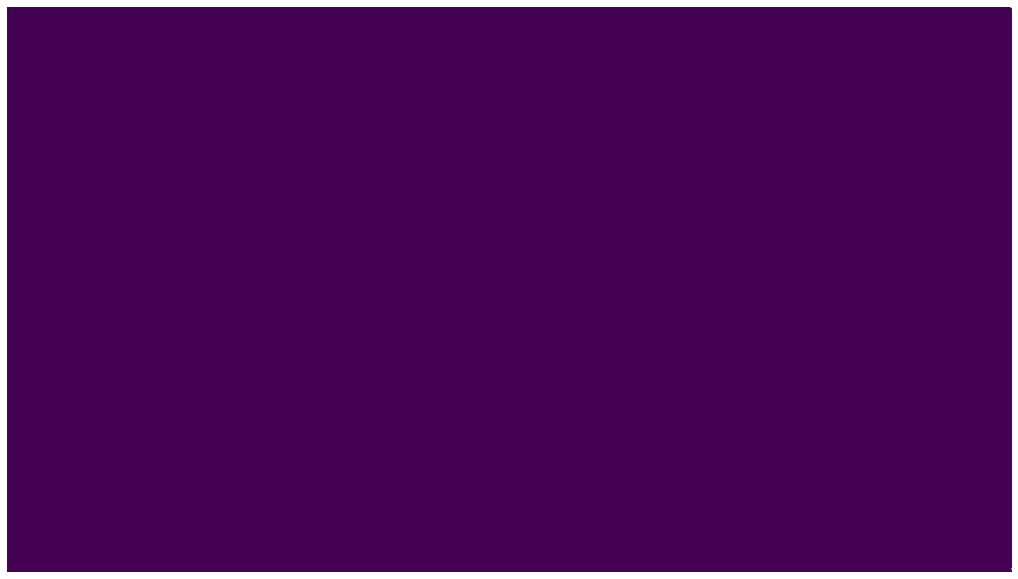

In [24]:
xb, yb = next(iter(val_dl))
#for xb, yb in tqdm(next(iter(val_dl)), leave=False):
xb, yb = xb.float(), yb.float()
xb, yb = xb.cuda(), yb.cuda()
output = re_load_trained_model(xb)
print(f'output shape is {output.shape}')
numpy_out_1 = output[0].cpu().detach().numpy()
print(numpy_out_1.shape)
show_depth_image(numpy_out_1[0])

In [25]:
numpy_out_1[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.08979531,
        0.11933673],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01834593],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05131291],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [30]:
real_depth = yb.cpu().detach().numpy()

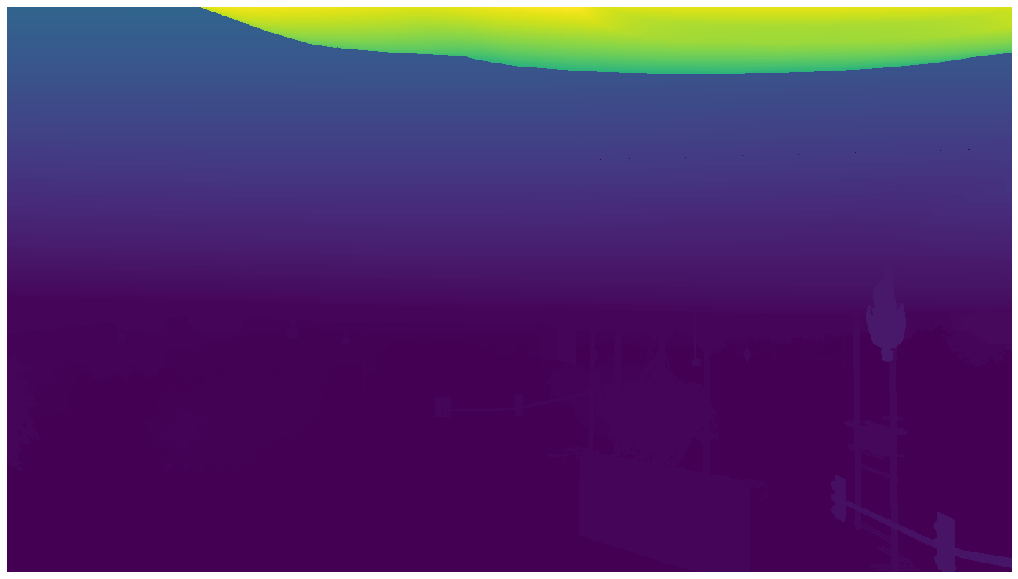

In [31]:
show_depth_image(real_depth[0])

In [32]:
real_colour = xb.cpu().detach().numpy()

In [43]:
real_colour_0 = real_colour[0].reshape(int(720),1280 ,- 1)
real_colour_0 = real_colour_0/255

In [46]:
real_colour_0.shape

(720, 1280, 3)

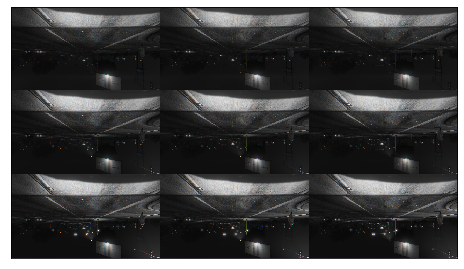

In [47]:
show_img(real_colour_0)

# Standardisation

train dataloader is called tr_dl

In [21]:
mean = 0.0
count_mn = 0
for images, _ in tr_dl:
    images = images.float()
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    print(f"Whirrrrrr calculating..... {count_mn} of {train_size/batch_sz}")
    count_mn+= 1
mean = mean / len(tr_dl.dataset)


Whirrrrrr calculating..... 0 of 392.8125
Whirrrrrr calculating..... 1 of 392.8125
Whirrrrrr calculating..... 2 of 392.8125
Whirrrrrr calculating..... 3 of 392.8125
Whirrrrrr calculating..... 4 of 392.8125
Whirrrrrr calculating..... 5 of 392.8125
Whirrrrrr calculating..... 6 of 392.8125
Whirrrrrr calculating..... 7 of 392.8125
Whirrrrrr calculating..... 8 of 392.8125
Whirrrrrr calculating..... 9 of 392.8125
Whirrrrrr calculating..... 10 of 392.8125
Whirrrrrr calculating..... 11 of 392.8125
Whirrrrrr calculating..... 12 of 392.8125
Whirrrrrr calculating..... 13 of 392.8125
Whirrrrrr calculating..... 14 of 392.8125
Whirrrrrr calculating..... 15 of 392.8125
Whirrrrrr calculating..... 16 of 392.8125
Whirrrrrr calculating..... 17 of 392.8125
Whirrrrrr calculating..... 18 of 392.8125
Whirrrrrr calculating..... 19 of 392.8125
Whirrrrrr calculating..... 20 of 392.8125
Whirrrrrr calculating..... 21 of 392.8125
Whirrrrrr calculating..... 22 of 392.8125
Whirrrrrr calculating..... 23 of 392.8125
Wh

NameError: name 'count_var' is not defined

In [22]:
mean

tensor([ 98.2207, 101.6702, 102.9898])

In [24]:

var = 0.0
count_var =0
for images, _ in tr_dl:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
    print(f"Whirrrrrr calculating..... {count_var} of {train_size/batch_sz}")
    count_var+= 1
std = torch.sqrt(var / (len(tr_dl.dataset)*720*1280))

Whirrrrrr calculating..... 0 of 392.8125
Whirrrrrr calculating..... 1 of 392.8125
Whirrrrrr calculating..... 2 of 392.8125
Whirrrrrr calculating..... 3 of 392.8125
Whirrrrrr calculating..... 4 of 392.8125
Whirrrrrr calculating..... 5 of 392.8125
Whirrrrrr calculating..... 6 of 392.8125
Whirrrrrr calculating..... 7 of 392.8125
Whirrrrrr calculating..... 8 of 392.8125
Whirrrrrr calculating..... 9 of 392.8125
Whirrrrrr calculating..... 10 of 392.8125
Whirrrrrr calculating..... 11 of 392.8125
Whirrrrrr calculating..... 12 of 392.8125
Whirrrrrr calculating..... 13 of 392.8125
Whirrrrrr calculating..... 14 of 392.8125
Whirrrrrr calculating..... 15 of 392.8125
Whirrrrrr calculating..... 16 of 392.8125
Whirrrrrr calculating..... 17 of 392.8125
Whirrrrrr calculating..... 18 of 392.8125
Whirrrrrr calculating..... 19 of 392.8125
Whirrrrrr calculating..... 20 of 392.8125
Whirrrrrr calculating..... 21 of 392.8125
Whirrrrrr calculating..... 22 of 392.8125
Whirrrrrr calculating..... 23 of 392.8125
Wh

In [25]:
std

tensor([63.4003, 64.1523, 64.4491])

In [29]:
Moderate_tr_stats = mean, std

mean is tensor([ 98.2207, 101.6702, 102.9898])
std is tensor([63.4003, 64.1523, 64.4491])

In [30]:
transforms.Normalize(*Moderate_tr_stats)

Normalize(mean=tensor([ 98.2207, 101.6702, 102.9898]), std=tensor([63.4003, 64.1523, 64.4491]))

In [45]:
normed_dataset = ModerateDataset(trans_on=True, transform=transforms.Normalize(*Moderate_tr_stats))

*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************


In [46]:
normed_dl = DataLoader(normed_dataset,  batch_size=batch_sz, shuffle=True,  num_workers=0)

In [48]:
next(iter(normed_dl))

[tensor([[[[2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3],
           ...,
           [3, 3, 3,  ..., 3, 3, 3],
           [3, 3, 3,  ..., 3, 3, 3],
           [3, 3, 3,  ..., 3, 3, 3]],
 
          [[2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           ...,
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3]],
 
          [[2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           ...,
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3]]],
 
 
         [[[3, 3, 3,  ..., 0, 0, 0],
           [3, 3, 3,  ..., 0, 0, 0],
           [3, 3, 3,  ..., 0, 0, 0],
           ...,
           [2, 2, 2,  ..., 1, 1, 1],
           [2, 2, 2,  ..., 1, 1, 1],
           [2, 2, 2,  ..., 1, 1, 1]],
 
          [[3, 3, 3,  ..., 0, 0, 